# Analyse ADXL345 Datasets:

- Data source: https://studio.edgeimpulse.com/public/36985/latest/acquisition/training
- Scenarios: `idle, left_right, up_down, circle`

In [33]:
import sys
sys.path.append("C:/Users/pmdsc/IdeaProjects/SirPopper/paper_reviews_collaborations/")
from preamble import *
import importlib
_ = importlib.reload(sys.modules['preamble'] )

In [44]:
def compile_impulse_dataset_from_json(glob_path='ADXL_GestureDataset/*.json'):
    dfr = pd.DataFrame()
    for seq, fn in enumerate(glob.glob(glob_path)):
        jdf = pd.read_json(fn)
        interval_ms = jdf['payload'].loc['interval_ms']
        columns = jdf['payload'].loc['sensors']
        values = jdf['payload'].loc['values']
        dft = pd.DataFrame(values, columns=[f"{c['name']}_{c['units']}" for c in columns])
        dft['meta_seq'] = seq
        dft['meta_interval_ms'] = interval_ms
        dft['target'] = fn.split('\\')[-1].split('.')[0]
        dft = dft.reset_index().rename(columns={'index':'meta_seq_num'})
        dft = dft.reindex(sorted(dft.columns), axis=1)
        dfr = pd.concat( [ dfr, dft ], ignore_index=True )
    return dfr    



## Train Set:

In [55]:
dfr = compile_impulse_dataset_from_json(glob_path='ADXL_GestureDataset/train/*.json')
display(dfr)
dfr.describe()

,accX_m/s2,accY_m/s2,accZ_m/s2,meta_interval_ms,meta_seq,meta_seq_num,target
0,-0.23,-1.25,10.63,16.666667,0,0,circle
1,-0.42,-1.26,10.60,16.666667,0,1,circle
2,-0.51,-1.26,10.53,16.666667,0,2,circle
3,-0.59,-1.23,10.53,16.666667,0,3,circle
4,-0.66,-1.25,10.42,16.666667,0,4,circle
...,...,...,...,...,...,...,...
9493,0.40,-0.02,5.62,16.666667,15,589,up_down
9494,0.64,-0.26,6.10,16.666667,15,590,up_down
9495,1.04,-0.41,6.74,16.666667,15,591,up_down
9496,1.20,-0.91,7.75,16.666667,15,592,up_down


,accX_m/s2,accY_m/s2,accZ_m/s2,meta_interval_ms,meta_seq,meta_seq_num
count,9498.000000,9498.000000,9498.000000,9.498000e+03,9498.000000,9498.000000
mean,0.254055,-1.012433,10.525372,1.666667e+01,7.500948,296.312697
std,2.899874,1.542622,2.616199,6.395221e-14,4.609375,171.373897
min,-11.750000,-6.970000,0.230000,1.666667e+01,0.000000,0.000000
25%,-0.880000,-1.820000,9.720000,1.666667e+01,4.000000,148.000000
50%,0.060000,-0.530000,10.670000,1.666667e+01,7.500000,296.000000
75%,1.030000,0.090000,11.180000,1.666667e+01,11.750000,445.000000
max,12.120000,3.720000,25.490000,1.666667e+01,15.000000,593.000000


#### Inspect Statistics by Class Type:
- Min / Max is approx 12 to -12.
- Means and Std are different among axes (x,y,z) and classes.

> ##### Finding:
> - `Requires numeric scaling` for inference and training.
> - The `same scaling parameters` are needed for both inference and training (e.g. min/max for normalization, or mean/std for standardization).
> - For this dataset, Min=-12 , Max=12.
> - Therefore, any inference data (from a new sensor device) must be scaled (calibrated) to the same rate.

- Mean 16.6 per interval_ms 
- Count `594, 593` time series entries per sequence.
- Approx `594*16.6 = 9860` milliseconds per sequence set (data file).

> ##### Finding: 
> Limited length `sliding windows` can be used in several ways. They have:
> - `window_size`: `n=2000/16.6=120`
> - `stride_length`: 
> 
> Prediction Data Modeling Options:
> - `as raw batch input` (classifier model: `n=120`) -> Outcome
> - `as statistically summarized batch input` (preprocessed features -> classifier model: `n=features`) -> Outcome
> - `as time series` (time series classifier model: `n=3x120`)  -> Outcome
> - `as noise removed time series` (noise removal -> time series classifier model: `n=3x120`)  -> Outcome

In [61]:
for t in dfr['target'].unique():
    print(t)
    display(dfr[dfr['target']==t][['accX_m/s2','accY_m/s2', 'accZ_m/s2', 'meta_seq_num', 'meta_interval_ms']].describe())

circle


,accX_m/s2,accY_m/s2,accZ_m/s2,meta_seq_num,meta_interval_ms
count,594.000000,594.000000,594.000000,594.000000,5.940000e+02
mean,0.982407,-0.825842,10.524949,296.500000,1.666667e+01
std,2.364399,1.978397,2.988256,171.617307,3.555708e-15
min,-3.950000,-4.670000,5.140000,0.000000,1.666667e+01
25%,-1.067500,-2.677500,8.005000,148.250000,1.666667e+01
50%,0.895000,-0.335000,10.315000,296.500000,1.666667e+01
75%,3.100000,0.930000,13.587500,444.750000,1.666667e+01
max,5.970000,2.180000,16.380000,593.000000,1.666667e+01


idle


,accX_m/s2,accY_m/s2,accZ_m/s2,meta_seq_num,meta_interval_ms
count,593.000000,593.000000,593.000000,593.000000,5.930000e+02
mean,0.212816,-0.212867,10.718094,296.000000,1.666667e+01
std,0.042191,0.019483,0.018091,171.328632,3.555713e-15
min,0.040000,-0.310000,10.640000,0.000000,1.666667e+01
25%,0.190000,-0.220000,10.710000,148.000000,1.666667e+01
50%,0.210000,-0.210000,10.720000,296.000000,1.666667e+01
75%,0.240000,-0.200000,10.730000,444.000000,1.666667e+01
max,0.400000,-0.130000,10.780000,592.000000,1.666667e+01


left_right


,accX_m/s2,accY_m/s2,accZ_m/s2,meta_seq_num,meta_interval_ms
count,594.000000,594.000000,594.000000,594.000000,5.940000e+02
mean,0.523754,-0.648973,10.704983,296.500000,1.666667e+01
std,2.456826,0.547261,0.787344,171.617307,3.555708e-15
min,-5.310000,-2.610000,7.590000,0.000000,1.666667e+01
25%,-1.127500,-0.997500,10.190000,148.250000,1.666667e+01
50%,0.365000,-0.595000,10.660000,296.500000,1.666667e+01
75%,2.250000,-0.272500,11.180000,444.750000,1.666667e+01
max,8.550000,0.810000,13.810000,593.000000,1.666667e+01


up_down


,accX_m/s2,accY_m/s2,accZ_m/s2,meta_seq_num,meta_interval_ms
count,594.000000,594.000000,594.000000,594.000000,5.940000e+02
mean,0.662643,-1.138990,10.611566,296.500000,1.666667e+01
std,0.901166,2.022458,4.468448,171.617307,3.555708e-15
min,-2.090000,-5.320000,2.760000,0.000000,1.666667e+01
25%,0.052500,-2.847500,6.775000,148.250000,1.666667e+01
50%,0.600000,-1.140000,10.540000,296.500000,1.666667e+01
75%,1.197500,0.437500,13.912500,444.750000,1.666667e+01
max,4.210000,2.860000,20.790000,593.000000,1.666667e+01


## Test Set:

In [78]:
dfr = compile_impulse_dataset_from_json(glob_path='ADXL_GestureDataset/test/*.json')
display(dfr)
dfr.describe()

,accX_m/s2,accY_m/s2,accZ_m/s2,meta_interval_ms,meta_seq,meta_seq_num,target
0,-0.11,0.91,10.12,16.666667,0,0,circle
1,-0.23,0.93,10.38,16.666667,0,1,circle
2,-0.22,0.96,10.52,16.666667,0,2,circle
3,-0.15,1.04,10.39,16.666667,0,3,circle
4,0.02,1.08,10.33,16.666667,0,4,circle
...,...,...,...,...,...,...,...
2370,0.54,-2.73,12.30,16.666667,3,589,up_down
2371,0.11,-2.39,11.80,16.666667,3,590,up_down
2372,-0.45,-2.04,11.23,16.666667,3,591,up_down
2373,-0.72,-1.76,10.95,16.666667,3,592,up_down


,accX_m/s2,accY_m/s2,accZ_m/s2,meta_interval_ms,meta_seq,meta_seq_num
count,2375.000000,2375.000000,2375.000000,2.375000e+03,2375.000000,2375.000000
mean,0.595566,-0.706876,10.639865,1.666667e+01,1.500211,296.375158
std,1.784347,1.478640,2.716452,1.421385e-14,1.118458,171.436987
min,-5.310000,-5.320000,2.760000,1.666667e+01,0.000000,0.000000
25%,-0.105000,-1.275000,9.895000,1.666667e+01,0.500000,148.000000
50%,0.240000,-0.240000,10.710000,1.666667e+01,2.000000,296.000000
75%,1.345000,-0.160000,11.260000,1.666667e+01,2.500000,445.000000
max,8.550000,2.860000,20.790000,1.666667e+01,3.000000,593.000000


In [42]:
from sklearn.preprocessing import StandardScaler
X = dfr[['accX_m/s2','accY_m/s2', 'accZ_m/s2']].to_numpy()
y = dfr['target'].to_numpy()
# X_encoded = UtilStats.Preprocess.one_hot_encode(X, ['col'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled, y

(array([[-0.16693141, -0.1540101 ,  0.0399946 ],
        [-0.23245495, -0.16049291,  0.02852698],
        [-0.26349241, -0.16049291,  0.0017692 ],
        ...,
        [ 0.27104173,  0.39054602, -1.44697345],
        [ 0.32621945,  0.06640547, -1.06089691],
        [ 0.15378908, -0.38090849, -0.60219212]]),
 array(['circle', 'circle', 'circle', ..., 'up_down', 'up_down', 'up_down'],
       dtype=object))

## Deployment / Model Export:
- Choosing Quantized `int8` models means that floating points are converted to 8-bit integers, in range -128 to 127, containing `n=256`-unique discrete values compared to the high-precision floating points (n=`(2^8-1)*2^24-1 = 4,278,190,079` [ref](https://stackoverflow.com/a/7744178)).
    - An example with this data on using a `NN=360>20>10>4`  Model illustrates the performance (model accuracy and inference time / memory) difference:

<table>
<tr><td>
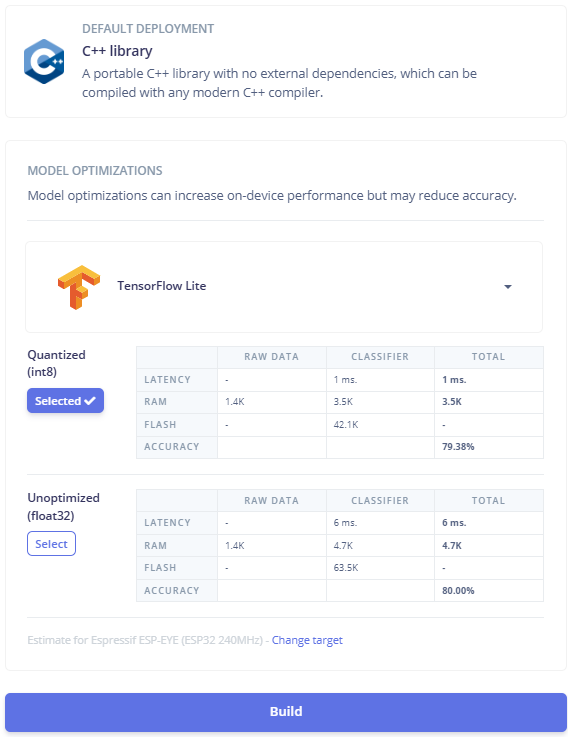
</td><td>
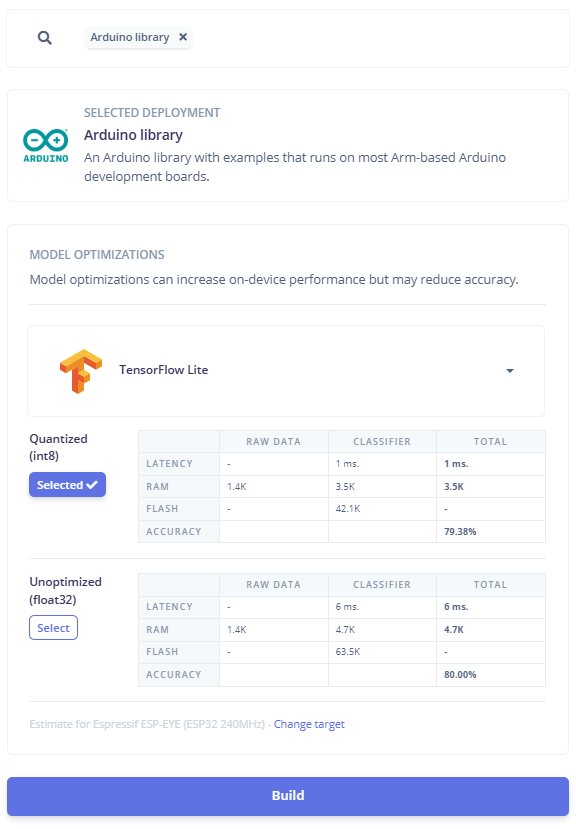
</tr>
<td>Exporting as Default C++</td>
<td>Exporting as Arduino Library</td>
</tr>
</table>

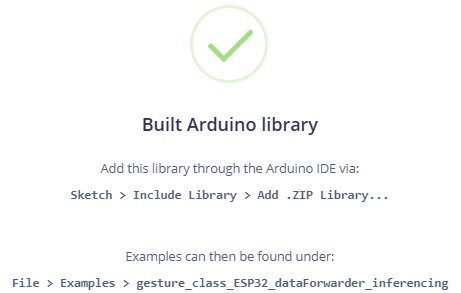
